# LSTMS FOR TRACKING

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf

import sys
sys.path.insert(0, "/home/usuario/project/src")

%load_ext autoreload
%autoreload

from dataset import Route

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

**Data preparation**

In [2]:
home_path = '/home/usuario/'

datasets_path = os.path.join(home_path, 'project_data', 'datasets')

all_datasets = ['KITTITrackletsCars', 'KITTITrackletsPersons',  'KITTITrackletsCarsPersons', 'KITTITrackletsCarsHard', 'KITTITrackletsCarsPersonsHard']

In [3]:
dataset_path = os.path.join(datasets_path, all_datasets[0])

In [4]:
# This is the output from the NN
predictions = pd.read_csv(os.path.join(dataset_path, "NN_output.csv"))
# This gives information about the paths
eval_info = pd.read_csv(os.path.join(dataset_path, "info_eval.csv"))
# Observation means for pc1 and pc2
means1 = np.load(os.path.join(dataset_path, 'observed_mean_pc1.npy'))
means2 = np.load(os.path.join(dataset_path, 'observed_mean_pc2.npy'))
# Observation medians for pc1 and pc2
medians1 = np.load(os.path.join(dataset_path, 'observed_median_pc1.npy'))
medians2 = np.load(os.path.join(dataset_path, 'observed_median_pc2.npy'))

In [5]:
# Angles correction Reduces the MSE from 200 to 66 degrees.
predictions.loc[predictions['pred_angles']>3, 'pred_angles'] = predictions[predictions['pred_angles']>3]['pred_angles'] - 3
predictions.loc[predictions['pred_angles']<-3, 'pred_angles'] = predictions[predictions['pred_angles']<-3]['pred_angles'] + 3

In [6]:
def routes_to_dict(eval_info, predictions, mean1, mean2, median1, median2):
    ''' Loads (meta)info from disk to memory classes for easy manipulation '''
    routes = dict()
    n_routes = eval_info.shape[0]
    
    for i in range(n_routes):
        current = eval_info.iloc[i]
        start_i = current['cumsum']
        n_points = current['n_points']
        current_pred = predictions.iloc[start_i:start_i+n_points]
        
        all_i = current['first_point']
        sliced_mean1 = mean1[all_i:all_i+n_points,:]
        sliced_mean2 = mean2[all_i:all_i+n_points,:]
        sliced_median1 = median1[all_i:all_i+n_points,:]
        sliced_median2 = median2[all_i:all_i+n_points,:]
        sliced_pred1 = predictions.loc[start_i:start_i+n_points-1,['pred_pc1center_x', 'pred_pc1center_y']].values
        sliced_pred2 = predictions.loc[start_i:start_i+n_points-1,['pred_pc2center_x', 'pred_pc2center_y']].values
        
        route_obj = Route(current['name'], current_pred)
        
        # Add the observation to the gt table
        route_obj.add_observation(obs_pc1=sliced_mean1, obs_pc2=sliced_mean2, name="mean")
        route_obj.add_observation(obs_pc1=sliced_median1, obs_pc2=sliced_median2, name="median")
        route_obj.add_observation(obs_pc1=sliced_pred1, obs_pc2=sliced_pred2, name="pred")

        routes[current['name']] = route_obj
            
    return routes

In [7]:
routes_dict = routes_to_dict(eval_info, predictions, mean1=means1, mean2=means2, median1=medians1, median2=medians2)

In [22]:
routes_dict['2_1'].ground_truth[['x','y']]

,x,y
0,-1.276125,0.078547
1,-1.276123,0.078548
2,-1.276123,0.078547
3,-1.276123,0.078548
4,-1.276123,0.078547
5,-1.322609,0.106676


In [23]:
routes_dict['2_1'].generated[['align3d_x','align3d_y']]

,align3d_x,align3d_y
0,-1.323092,0.093576
1,-1.352187,0.099064
2,-1.274132,0.091097
3,-1.303532,0.087160
4,-1.309425,0.084575
5,-1.386484,0.086078


### MODEL PREP AND TRAINING

In [8]:
def create_simple_dataset(routes_dict, k):
    total_count, able_count = 0, 0

    data = []
    pred = []

    for path in routes_dict.values():
        # Count of observations
        total_count += path.n_samples
        if path.n_samples <= k:
            continue       
        able_count += (path.n_samples-k)

        # Create the dataset
        for i in range(k, path.n_samples-k):
            indexes = list(range(i-k,i))
            data.append(path.routes.loc[indexes, ['pred_x', 'pred_y']].values.tolist())
            pred.append(path.routes.loc[i, ['gt_x', 'gt_y']].values.tolist())

    print("Percentage of tables: ", able_count/total_count)

    return np.array(data), np.array(pred)

In [20]:
def create_train_model(routes_dict, k, lstm_o, inputs, preds):
    
    total_count, able_count = 0, 0

    data = []
    pred = []

    for path in routes_dict.values():
        # Count of observations
        total_count += path.n_samples
        if path.n_samples <= k:
            continue       
        able_count += (path.n_samples-k)

        # Create the dataset
        for i in range(k, path.n_samples-k):
            indexes = list(range(i-k,i))
            
            if inputs == 'xy':
                single_obs = path.routes.loc[indexes, ['pred_x', 'pred_y']].values.tolist()
            elif inputs == 'vxvy':
                single_obs = path.generated.loc[indexes, ['align3d_x','align3d_y']].values.tolist()
            elif inputs == 'xyvxvy':
                single_obs = path.routes.loc[indexes, ['pred_x', 'pred_y']].values.tolist()
                single_obs.extend(path.generated.loc[indexes, ['align3d_x','align3d_y']].values.tolist())
            
            data.append(single_obs)

            if preds == "xy":
                single_pred = path.routes.loc[i, ['gt_x', 'gt_y']].values.tolist()
            elif preds == "vxvy":
                single_pred = path.ground_truth.loc[i, ['x','y']].values.tolist()
                
            pred.append(single_pred)

    print("Percentage of tables: ", able_count/total_count)
    
    data = np.array(data)
    pred = np.array(pred)
    
    # TODO: Convert this to lazy loading for when dealing with whole dataset
    # Prepare numpy arrays
    SPLIT = int(data.shape[0]*0.8)
    train_x = data[0:SPLIT]
    train_y = pred[0:SPLIT]

    val_x = data[SPLIT:]
    val_y = pred[SPLIT:]
    
    # Create dataset object
    BATCH_SIZE = 256
    BUFFER_SIZE = 10000

    train_data_single = tf.data.Dataset.from_tensor_slices((train_x, train_y))
    train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

    val_data_single = tf.data.Dataset.from_tensor_slices((val_x, val_y))
    val_data_single = val_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    
    # Model definition
    single_step_model = tf.keras.models.Sequential()
    single_step_model.add(tf.keras.layers.LSTM(32,
                                               input_shape=data.shape[-2:]))
    single_step_model.add(tf.keras.layers.Dense(2))

    single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse')
    
    EVALUATION_INTERVAL = 500
    EPOCHS = 10
    single_step_history = single_step_model.fit(train_data_single, 
                                            epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)
    return single_step_model

In [18]:
xy_8_model = create_train_model(routes_dict=routes_dict, k=8, inputs='xy', preds='xy')
xy_12_model = create_train_model(routes_dict=routes_dict, k=12, inputs='xy', preds='xy')

TypeError: create_train_model() missing 1 required positional argument: 'lstm_o'

In [13]:
xyalign_8_model = create_train_model(routes_dict=routes_dict, k=8, lstm_o=64, inputs='xyvxvy', preds='xy')
xyalign_12_model = create_train_model(routes_dict=routes_dict, k=12, lstm_o=64, inputs='xyvxvy', preds='xy')

Percentage of tables:  0.849943117178612
Train for 1000 steps, validate for 50 steps
Epoch 1/10
1000/1000 [==============================] - 52s 52ms/step - loss: 243.4312 - val_loss: 1.9303
Epoch 2/10
1000/1000 [==============================] - 43s 43ms/step - loss: 19.0554 - val_loss: 0.4488
Epoch 3/10
1000/1000 [==============================] - 35s 35ms/step - loss: 1.2436 - val_loss: 0.3518
Epoch 4/10
1000/1000 [==============================] - 38s 38ms/step - loss: 0.5613 - val_loss: 0.2294
Epoch 5/10
1000/1000 [==============================] - 33s 33ms/step - loss: 0.4055 - val_loss: 0.2637
Epoch 6/10
1000/1000 [==============================] - 33s 33ms/step - loss: 0.3353 - val_loss: 0.4645
Epoch 7/10
1000/1000 [==============================] - 36s 36ms/step - loss: 0.2914 - val_loss: 0.1812
Epoch 8/10
1000/1000 [==============================] - 33s 33ms/step - loss: 0.2598 - val_loss: 0.1415
Epoch 9/10
1000/1000 [==============================] - 21s 21ms/step - loss: 0.

In [21]:
align_8_model = create_train_model(routes_dict=routes_dict, k=8, lstm_o=32, inputs='vxvy', preds='vxvy')
align_12_model = create_train_model(routes_dict=routes_dict, k=12, lstm_o=32, inputs='xyvxvy', preds='vxvy')

Percentage of tables:  0.849943117178612
Train for 500 steps, validate for 50 steps
Epoch 1/10
500/500 [==============================] - 17s 35ms/step - loss: 0.0203 - val_loss: 0.0021
Epoch 2/10
500/500 [==============================] - 9s 19ms/step - loss: 0.0047 - val_loss: 0.0019
Epoch 3/10
500/500 [==============================] - 11s 22ms/step - loss: 0.0043 - val_loss: 0.0018
Epoch 4/10
500/500 [==============================] - 10s 19ms/step - loss: 0.0042 - val_loss: 0.0017
Epoch 5/10
500/500 [==============================] - 9s 18ms/step - loss: 0.0041 - val_loss: 0.0018
Epoch 6/10
500/500 [==============================] - 10s 19ms/step - loss: 0.0040 - val_loss: 0.0017
Epoch 7/10
500/500 [==============================] - 12s 23ms/step - loss: 0.0039 - val_loss: 0.0017
Epoch 8/10
500/500 [==============================] - 10s 21ms/step - loss: 0.0038 - val_loss: 0.0018
Epoch 9/10
500/500 [==============================] - 9s 17ms/step - loss: 0.0037 - val_loss: 0.0018
E

### STORING DATA AND VISUALIZATION

In [29]:
def compute_lstm(route, model, k, store_name, inputs, generates_route=False):
    if route.n_samples <= k:
        #print("Cant compute this route n_samples < k!")
        return
    
    val_x = []
    # For each route create a list with predictable inputs
    # TODO: 
    for i in range(k, route.n_samples):
        indexes = list(range(i-k,i))
        # 
        if inputs == 'xy':
            single_obs = route.routes.loc[indexes, ['pred_x', 'pred_y']].values.tolist()
        elif inputs == 'vxvy':
            single_obs = route.generated.loc[indexes, ['align3d_x','align3d_y']].values.tolist()
        elif inputs == 'xyvxvy':
            single_obs = route.routes.loc[indexes, ['pred_x', 'pred_y']].values.tolist()
            single_obs.extend(path.generated.loc[indexes, ['align3d_x','align3d_y']].values.tolist())
        val_x.append(single_obs)
    
    # Compute the predictions
    predictions = model.predict(val_x)
    
    if generates_route:
        # Store in route and compute error
        route.routes.loc[k:,f'{store_name}_x'] = predictions[:,0]
        route.routes.loc[k:,f'{store_name}_y'] = predictions[:,1]
        # Assign the predicted values to k<i values
        route.routes.loc[:k,[f'{store_name}_x',f'{store_name}_y']] = route.routes.loc[:k, ['pred_x', 'pred_y']].values
        route.routes.loc[:,f'{store_name}_a'] = 0
        
        route.name_routes.position.append(store_name)
    else:
        route.generated.loc[k:,f'{store_name}_x'] = predictions[:,0]
        route.generated.loc[k:,f'{store_name}_y'] = predictions[:,1]
        route.generated.loc[:k,[f'{store_name}_x',f'{store_name}_y']] = route.routes.loc[:k, ['pred_x', 'pred_y']].values

        route.generated.loc[:,f'{store_name}_a'] = 0

        self.name_routes.translation.append(store_name)

    

In [30]:
for key, route in routes_dict.items():    
    # Check if this route can compute LSTM prediction
    if route.n_samples <= 8:
        # TODO: Add log to this system
        route.compute_routes()
        route.compute_all_rmse()
        pass 
    
    #compute_lstm(route=route, model=xy_8_model, k=8, store_name="lstm_xy_8", align=False)
    #compute_lstm(route=route, model=xyalign_8_model, k=8, store_name="lstm_xy+align_8", align=True )
    compute_lstm(route=route, model=align_8_model, k=8, store_name="lstm_align_8", inputs='vxvy', generates_route=True)
    if route.n_samples <= 12:
        route.compute_routes()
        route.compute_all_rmse()
        pass 
    #compute_lstm(route=route, model=xy_12_model, k=12, store_name="lstm_xy_12", align=False)
    compute_lstm(route=route, model=align_12_model, k=12, store_name="lstm_align_12", inputs='vxvy', generates_route=True)
    
    # Compute routes and errors
    route.compute_routes()
    route.compute_all_rmse()

ValueError: Error when checking input: expected lstm_1_input to have shape (24, 2) but got array with shape (12, 2)

In [16]:
import matplotlib.pyplot as plt
from matplotlib import patches

#%matplotlib notebook
#plt.rcParams['figure.figsize'] = 8, 8

import mpld3
mpld3.enable_notebook()
plt.rcParams['figure.figsize'] = 20,10

In [17]:
def plot_two_route(route, pos_names = None, trans_names=None, arrows=False, save=False):
    """ Plots given route from DataFrame
        Show both the ground truth and the predicted
    """
    
    # Link axis (?)
    #fig, ax = plt.subplots(1, 2, figsize=(20,10),sharex='row', sharey='row')
    fig, ax = plt.subplots(1, 2, figsize=(20,10))


    colours_trans = ['orange', 'red', 'blue', 'magenta','lime', 'purple']

    colours_pos = ['black', 'green', 'pink', 'cyan', 'navy', 'yellow', 'grey', 'red', 'blue']

    # We build two different axis for relative and absolute
    for axis, motion in zip(ax.flat, ['relative', 'absolute']):
        
        # Always plot ground thruth
        for i, name in enumerate(pos_names):
            axis.plot(route.routes[f'{name}_x'], route.routes[f'{name}_y'], '-ok', color=colours_pos[i], label=f'{name} RMSE: {route.trans_error[name]:.4f}')

        # And plot each route on the axis STEP ROUTES
        for i, name in enumerate(trans_names):
            name_var = f'{name}_{motion}'
            axis.plot(route.routes[f'{name_var}_x'], route.routes[f'{name_var}_y'], '-ok', color=colours_trans[i], label=f'{name} RMSE: {route.trans_error[name_var]:.4f}')

        # Set axis and legend to axis
        axis.legend(prop={'size': 15})
        axis.set_title(f"route: {route.name} {motion}", size=20)
        
    
    # TODO: fix arrows
    if arrows:
        # Add the arrows
        for posx, posy, ang in zip(pc_p[0], pc_p[1], pc_a):
            ax.add_patch(create_arrow(posx, posy, ang, 'black', mean_dist/7))
        for posx, posy, ang in zip(pr_p[0], pr_p[1], pr_a):
            ax.add_patch(create_arrow(posx, posy, ang, 'orange', mean_dist/7))
        for posx, posy, ang in zip(kf_p[0], kf_p[1], kf_a):
            ax.add_patch(create_arrow(posx, posy, ang, 'red', mean_dist/7))
    
    if save:
        fig.savefig(f'./imgs/{route.name}.svg', format='svg', dpi=1200)


In [18]:
i = 20

In [19]:
#r.routes[['gt_x','gt_y','pred_x','pred_y','lstm_xy+align_8_x','lstm_xy+align_8_y']]

NameError: name 'r' is not defined

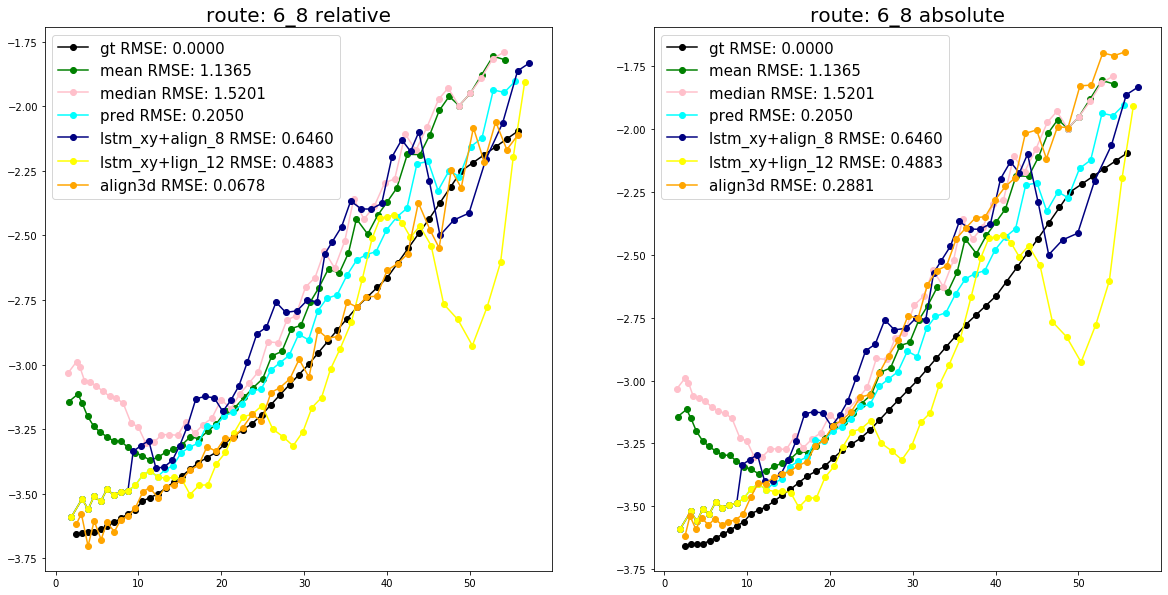

In [25]:
r = routes_dict[list(routes_dict.keys())[i]]
plot_two_route(route=r, pos_names=r.name_routes.position, trans_names=r.name_routes.translation, save=True)
i += 1

In [21]:
import json
from itertools import chain
from collections import defaultdict

def export_results(routes_dict):
    ''' Dump rmse to json file '''
    
    error_dict, count_dict = defaultdict(int), defaultdict(int)
    for name, route in routes_dict.items():
        #print(name)
        keys = route.name_routes.position+list(chain.from_iterable([[route+'_relative', route+'_absolute'] for route in route.name_routes.translation]))
        for key in keys: 
            # trans_error could be absolute error (without dividing by number of samples )
            error_dict[key] += route.trans_error[key]
            count_dict[key] += 1

    for key in error_dict.keys():
        # TODO: Make ponderated mean
        #error_dict[key] = error_dict[key]/len(routes_dict)
        error_dict[key] = error_dict[key]/count_dict[key]

    jsonf = json.dumps(error_dict, indent=4)    
    f = open("./imgs/results.json","w")
    f.write(jsonf)
    f.close()
    
    return error_dict

## export_results(routes_dict)